<a href="https://colab.research.google.com/github/benjaminnigjeh/keyProteoforms/blob/main/explainableAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update -qq
!apt-get install -y -qq mono-complete
!pip install -qq fisher-py

#Import external libraries

In [19]:
from fisher_py.data.business import Scan
from fisher_py import RawFile

from google.colab import files

import re
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess

from scipy.signal import find_peaks
from scipy.signal import savgol_filter

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from sklearn.datasets import make_classification
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

#Helper functions

In [95]:
def helper_regex(text):
    match = re.search(rf"{'Full'}\s+(\w+)", text)
    if match:
        return match.group(1)
    return None

def MS1Casting(folder_path, file_path):
    os.chdir(folder_path)
    raw = RawFile(file_path)
    data_intensities = [0]*1369
    for i in tqdm(range(1, raw.number_of_scans)):
                raw_scan = Scan.from_file(raw._raw_file_access, scan_number=i)
                if str(helper_regex(raw_scan.scan_type)) == 'ms':
                        scan_masses = raw_scan.preferred_masses
                        scan_intensities = raw_scan.preferred_intensities
                        for j in range(0,len(scan_masses)):
                                index = round(scan_masses[j])
                                if index > 600 and index < 1969:
                                        data_intensities[index-600] = scan_intensities[j] + data_intensities[index-600]
    return(data_intensities)

def MS1Casting_highres(folder_path, file_path):
    os.chdir(folder_path)
    raw = RawFile(file_path)
    data_intensities = [0]*13690
    for i in tqdm(range(1, raw.number_of_scans)):
                raw_scan = Scan.from_file(raw._raw_file_access, scan_number=i)
                if str(helper_regex(raw_scan.scan_type)) == 'ms':
                        scan_masses = raw_scan.preferred_masses
                        scan_intensities = raw_scan.preferred_intensities
                        for j in range(0,len(scan_masses)):
                                index = int((round(scan_masses[j], 1))*10)
                                if index > 6000 and index < 19690:
                                        data_intensities[index-6000] = scan_intensities[j] + data_intensities[index-6000]
    return(data_intensities)

def deconvolute(target_list, intensity, i):
    masses = []
    intensities = []

    for target in target_list:
        for m, inten in zip(mass, intensity):
            if m > (target - 5) and m < (target + 5):
                masses.append(m)
                intensities.append(inten)

    data = {
                'Column1': masses,
                'Column2': intensities}
    df = pd.DataFrame(data)
    file_name = '/content/' + str(i) + 'temp.txt'
    df.to_csv(file_name, sep='\t', index=False)
    command = f"python -m unidec -f {file_name}"
    subprocess.run(command, shell=True)
    return()

#Generate high-resolution dataset

In [ ]:
folder_path = 'D:/conv/samples/'

os.chdir(folder_path)

file_path_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

result = []

for file_path in file_path_list:
    print(file_path)
    folder_path = 'D:/conv/samples/'
    result.append(MS1Casting_highres(folder_path, file_path))

df = pd.DataFrame(result)

column_max = df.max()

df_normalized = df / (column_max + 0.001)

df_normalized['target'] = file_path_list

df_normalized.to_csv('D:/res.csv')

#Import dataset

In [27]:
dataset = files.upload_file('dataset')
df = pd.read_csv('/content/dataset')

X = df.copy()
Y = X.pop("target")
X_train = np.array(X)
y_train = np.array(Y)

X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)


Saved res_insoluble_sorted.csv to /content/dataset


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# List to store the results for each fold
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    print(f"\nTraining fold {fold}/{k}...")

    # Split the data into train and validation sets for this fold
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Define the model
    model = Sequential()
    model.add(Dense(128, input_dim=13690, activation='relu',
                    kernel_regularizer=regularizers.l1(0.01)))  # L1 regularization
    model.add(Dense(32, activation='relu'))  # Hidden layer with 32 units
    model.add(Dense(1, activation='sigmoid'))  # Output layer with a single neuron for binary classification

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, validation_data=(X_val_fold, y_val_fold))

    # Store the result for this fold
    fold_results.append(history.history)

# You can now analyze the results of each fold (e.g., accuracy, loss over epochs)

# After running K-fold validation, plot the loss across all folds
for fold_idx, history in enumerate(fold_results):
    #plt.plot(history['loss'], label=f'Train Loss Fold {fold_idx + 1}')
    plt.plot(history['val_loss'], label=f'Val Loss Fold {fold_idx + 1}')

# Add title, labels, and legend
plt.title('Binary Cross-Entropy Loss vs Epoch (Across Folds)')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf

# Assuming you have a list of models trained across folds
# Store the models from each fold in a list
models_from_folds = []  # This list will store models from each fold

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    # Define the model and compile it as usual
    model = Sequential()
    model.add(Dense(128, input_dim=13690, activation='relu',
                    kernel_regularizer=regularizers.l1(0.01)))  # L1 regularization
    model.add(Dense(32, activation='relu'))  # Hidden layer with 32 units
    model.add(Dense(1, activation='sigmoid'))  # Output layer with a single neuron for binary classification
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model (using the fold's training data)
    model.fit(X_train[train_idx], y_train[train_idx], epochs=50, batch_size=32, validation_data=(X_train[val_idx], y_train[val_idx]))

    # Save the trained model
    models_from_folds.append(model)




In [89]:


# Assuming you have the models from each fold stored in models_from_folds
# X_train is the training data (make sure it's converted to tensor format)
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)

# Function to compute gradients across all models and average them
def compute_gradients_across_models_for_all_samples(X_train_samples, models):
    gradients_list = []  # To store the gradients for all samples

    # Iterate over each sample in the training set
    for sample_input in X_train_samples:
        sample_input = tf.expand_dims(sample_input, axis=0)  # Add batch dimension
        sample_gradients_list = []  # To store the gradients for this particular sample

        # Compute gradients for each model trained in the K-fold process
        for model in models:
            with tf.GradientTape() as tape:
                tape.watch(sample_input)  # Watch the input sample
                predictions = model(sample_input, training=False)  # Make predictions
            gradients = tape.gradient(predictions, sample_input)  # Compute gradients
            sample_gradients_list.append(gradients)

        # Average the gradients for this sample across all models
        avg_sample_gradients = tf.reduce_mean(tf.stack(sample_gradients_list), axis=0)
        gradients_list.append(avg_sample_gradients)

    # Average the gradients for all samples across the entire training set
    avg_gradients_all_samples = tf.reduce_mean(tf.stack(gradients_list), axis=0)
    return avg_gradients_all_samples

# Compute average gradients across all samples in X_train
average_gradients = compute_gradients_across_models_for_all_samples(X_train_tensor, models_from_folds)

y = average_gradients.numpy().flatten()
x = np.arange(600, 1969, 0.1)


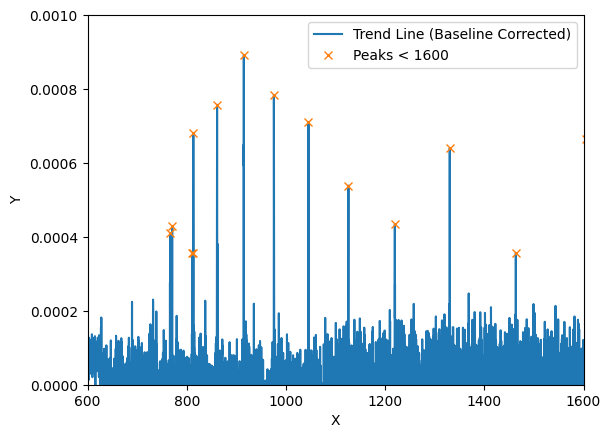

In [90]:
# Apply baseline correction (subtract the baseline)
# Using Savitzky-Golay filter to remove the baseline trend
baseline = savgol_filter(y, window_length=13690, polyorder=3)  # Smoothing the signal
corrected_y = y - baseline # Subtract baseline to remove it

# Apply a 2-point moving average to the corrected signal to get the trend line
trend_line = np.convolve(corrected_y, np.ones(2)/2, mode='valid')

# Define the minimum peak height (this is the threshold for peak detection)
min_peak_height = 0.0003  # Change this value based on your signal

# Find the peaks in the trend line with the defined height threshold
peaks, _ = find_peaks(trend_line, height=min_peak_height, distance=10)

# Filter peaks with y-values less than 1600
filtered_peaks = peaks[trend_line[peaks] < 1600]

# Plot the data and the detected peaks
plt.plot(x[:len(trend_line)], trend_line, label='Trend Line (Baseline Corrected)')
plt.plot(x[filtered_peaks], trend_line[filtered_peaks], "x", label='Peaks < 1600')
plt.xlabel('X')
plt.xlim([600, 1600])
plt.ylim([0, 0.0010])
plt.ylabel('Y')
plt.legend()
plt.show()

# Output the filtered peak values
peak_x_values = x[filtered_peaks]
peak_y_values = trend_line[filtered_peaks]


In [76]:
target = list(peak_x_values)
target_list = [num for num in target if num > 800]

In [92]:
dataset = files.upload_file('dataset')
df = pd.read_csv('/content/dataset')

X = df.copy()
Y = X.pop("target")
X = np.array(X)
y = np.array(Y)

#mass = [round(x * 0.1, 1) for x in range(6000, 19690)]
mass = x

intensity = list(X[0])

Saved res_insoluble_sorted.csv to /content/dataset


In [93]:
disease = [0] * len(X[0])  # Initialize the disease list for summing
healthy = [0] * len(X[0])  # Initialize the healthy list for summing

# Iterate through all entries in y
for i in range(len(y)):
    if y[i] == 1:
        # Add features to the disease group
        disease = [x + feature for x, feature in zip(disease, X[i])]
    elif y[i] == 0:
        # Add features to the healthy group
        healthy = [x + feature for x, feature in zip(healthy, X[i])]

# Now `disease` and `healthy` hold the sum of features for each group


In [96]:
deconvolute(target_list, disease, 1)
deconvolute(target_list, healthy, 0)

()